# Sequences, Time Series and Prediction
- **Week 1** Sequences and Prediction
  Got to know about trends, seasonality and noise. Used *naive forecasting* and *moving averages*.
- **Week 2** Deep Neural Networks for Time Series
  Used the TF Data API to pipeline Time Series data into a DNN model. The pipeline windows the data, where each window contains features and a label.
- **Week 3** Recurrent Neural Networks for Time Series


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Week 1 - Sequences and Prediction


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level, seed=42)

## Split into Training and Validation Set

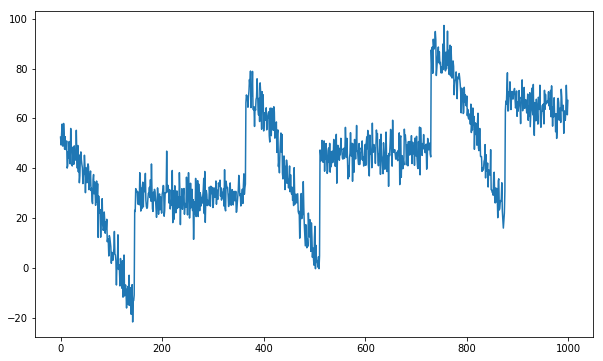

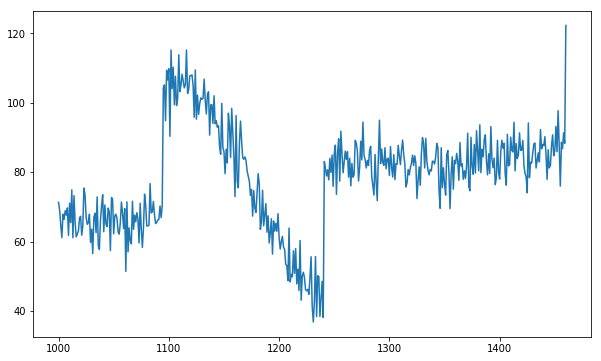

In [3]:
split_time = 1000
time_training = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plt.plot(time_training, x_train)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.show()

## Naive Forecast
Naive Forecast takes the value of the previous timestap to predict the value at the next timestap
n[i] = x[i-1]

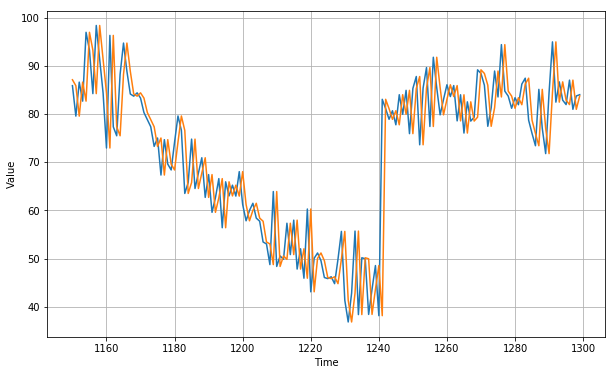

In [4]:
naive_forecast = series[split_time-1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=150, end=300)
plot_series(time_valid, naive_forecast, start=150, end=300)

To evaluate the model we calculate the **mean squared error** (MSE) or the **mean absolute error** (MAE)
MSE = $\frac{1}{i} \sum_{i=1}^{n} (Y_i - \hat Y_i)^2
MAE = $\frac{1}{i} \sum_{i=1}^{n} \abs{Y_i - \hat Y_i}

In [5]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.82753244997503
5.937908244831196


## Moving average
Takes the median over n timestep values to forecast the following value, where n is the window size.
m[i] = $\frac{1}{n} \sum_{j = i-n}^{i-1} Y_j$

In [6]:
def moving_average_forecast(series, window_size):
    """Forecast the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series)-window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

106.67456949384717
7.142418740162603


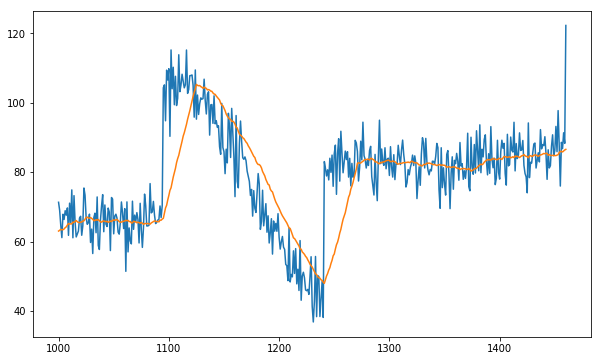

In [7]:
moving_average = moving_average_forecast(series, 30)[split_time - 30:]
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, moving_average)
print(tf.keras.metrics.mean_squared_error(x_valid, moving_average).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_average).numpy())

## Week 2 - DNN for Time Series

In [78]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

### Prepare Data Pipeline (TF Data API)
- window data ([1, 2, 3, 4, 5, ...] -> [1, 2], [2, 3], [3, 4], ...
- convert to numpy array flat_map + batch
- split into features and labels

In [92]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [93]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss="mse")
model.fit(dataset, epochs=100, verbose=0)

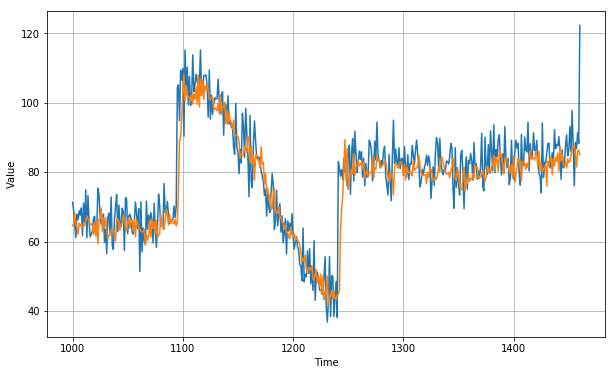

In [94]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [97]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

5.089072
